# LRP Tutorial for Pretrained VGG16 Model

This notebook demonstrates how to apply the Layer-Wise Relevance Propagation (LRP) algorithm on a pretrained VGG16 model using a sample image.

The relevance of each pixel is visualized by overlaying them on the example image.

Further details regarding the operating principles of LRP can be found at [heatmapping.org](http://heatmapping.org/) and [here](https://www.springerprofessional.de/layer-wise-relevance-propagation-an-overview/17153814).

The tutorial uses the same sample image and rule configuration as in [this](https://git.tu-berlin.de/gmontavon/lrp-tutorial) PyTorch implemenation.




Note: Before running this tutorial, please install the torchvision and PIL packages.


In [2]:
import torch
from PIL import Image
from torchvision import models, transforms

from captum.attr import LRP
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule

Loads the sample image and performs the appropriate normalizing steps.

In [6]:
img = Image.open("img/lrp/castle.jpg")

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # needed for application of ResNet, VGGNet, ...
    ]
)

X = torch.unsqueeze(transform(img), 0)

Loads pretrained VGG16 model and sets it to eval mode

In [7]:
model = models.vgg16(pretrained=True)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Generates a list list of all model layers.

In [9]:
layers = list(model._modules["features"]) + list(model._modules["classifier"])
number_layers = len(layers)

Assigns rules to every layers. This is an important step. In the literature one can find recommendations when to use which layer.

In [10]:
for idx_layer in range(1, number_layers)[::-1]:
    if idx_layer <= 16:
        setattr(layers[idx_layer], "rule", GammaRule())
    if 17 <= idx_layer <= 30:
        setattr(layers[idx_layer], "rule", EpsilonRule())
    if idx_layer >= 31:
        setattr(layers[idx_layer], "rule", EpsilonRule(epsilon=0))  # LRP-0

Applied <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7f7541fbc3d0> on layer Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Applied <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7f7541fbc610> on layer Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Applied <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7f756a93c8b0> on layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Applied <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7f760447bee0> on layer Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Applied <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7f75640c58e0> on layer Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Applied <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7f75640c5fa0> on layer MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Applied <captum.attr._utils.lrp_rules.EpsilonRule object at 0x7f75640c59d0

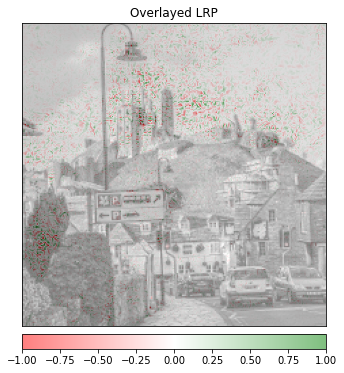

In [12]:
lrp = LRP(model)
attribution = lrp.attribute(X, target=483, verbose=True)  # castle -> 483
attribution = attribution.squeeze().permute(1, 2, 0).detach().numpy()

_ = viz.visualize_image_attr(
    attribution,
    img,
    method="blended_heat_map",
    sign="all",
    show_colorbar=True,
    title="Overlayed LRP",
)